<a href="https://colab.research.google.com/github/Tristan-Brown1096/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
import pandas as pd
import numpy as np
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 604kB 12.5MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 3.1MB 13.1MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 296kB 37.5MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=b287bc8f47d69d73ba0f929c5932895df2a419a7f23902c6c6de757d7d71a60a
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291990 sha256=4c4a679d866abf669b138d3c97c90939ed52e7dfa4e05b6b17e303bc0ea839f5
  Stored in directory: /root/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built htmlmin image

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Tristan-Brown1096/DS18_Unit_2_Build_Week_Project/master/data/cbb.csv')

In [3]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df.TEAM = [team.replace(' ', '') for team in df.TEAM]

In [9]:
df = df[df['POSTSEASON'] != 'no tourney']

In [10]:
train = df[df['YEAR'] <= 2017]
val = df[df['YEAR'] == 2018]
test = df[df['YEAR'] == 2019]

In [11]:
train['YEAR'] = train['YEAR'].astype(str)
val['YEAR'] = val['YEAR'].astype(str)
test['YEAR'] = test['YEAR'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [12]:
train['ID'] = train.TEAM + train.YEAR
val['ID'] = val.TEAM + val.YEAR
test['ID'] = test.TEAM + test.YEAR
train = train.set_index('ID')
val = val.set_index('ID')
test = test.set_index('ID')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [13]:
target = 'POSTSEASON'

In [54]:
X_train = train.drop([target, 'TEAM', 'YEAR', 'SEED', 'Unnamed: 0', 'Unnamed: 0.1', 'CONF'], axis=1)
y_train = train[target]

X_val = val.drop([target, 'TEAM', 'YEAR', 'SEED', 'Unnamed: 0', 'Unnamed: 0.1', 'CONF'], axis=1)
y_val = val[target]

X_test = test.drop([target, 'TEAM', 'YEAR', 'SEED', 'Unnamed: 0', 'Unnamed: 0.1', 'CONF'], axis=1)
y_test = test[target]

In [55]:
baseline = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline)

Baseline Accuracy: 0.4731977818853974


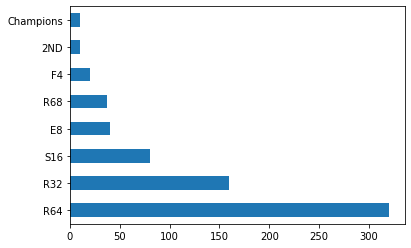

In [56]:
df.POSTSEASON.value_counts().plot(kind='barh')

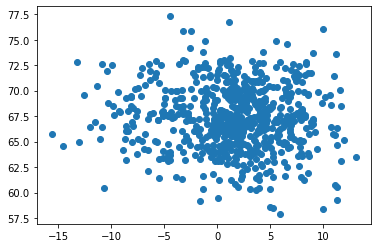

In [57]:
plt.scatter(df['WAB'], df['ADJ_T'])

In [58]:
scaler = StandardScaler()
Xt_train = scaler.fit_transform(X_train)
Xt_val = scaler.transform(X_val)
Xt_test = scaler.transform(X_test)

In [59]:
pca = PCA(.95)
pca_train = pca.fit_transform(Xt_train)
pca_val = pca.transform(Xt_val)
pca_test = pca.transform(Xt_test)

In [60]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5, max_features=None, criterion='entropy')
)

model.fit(pca_train, y_train)
print('Training accuracy:', model.score(pca_train, y_train))
print('Validation accuracy:', model.score(pca_val, y_val))
print('Test Accuracy', accuracy_score(y_test, model.predict(pca_test)))

Training accuracy: 0.8022181146025879
Validation accuracy: 0.5147058823529411
Test Accuracy 0.47058823529411764


In [61]:
model_2 = make_pipeline(
    RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5, max_features=None, criterion='entropy')
)

model_2.fit(X_train, y_train)
print('Training accuracy:', model_2.score(X_train, y_train))
print('Validation accuracy:', model_2.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, model_2.predict(X_test)))

Training accuracy: 0.7837338262476895
Validation accuracy: 0.6323529411764706
Test Accuracy 0.6029411764705882


In [45]:
from xgboost import XGBClassifier

In [62]:
model_3 = make_pipeline(
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_3.fit(X_train, y_train)
print('Training accuracy:', model_3.score(X_train, y_train))
print('Validation accuracy:', model_3.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, model_3.predict(X_test)))

Training accuracy: 0.9408502772643254
Validation accuracy: 0.5882352941176471
Test Accuracy 0.5


In [63]:
model_4 = make_pipeline(
    XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.01)
)

model_4.fit(X_train, y_train)
print('Training accuracy:', model_4.score(X_train, y_train))
print('Validation accuracy:', model_4.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, model_4.predict(X_test)))

Training accuracy: 0.6820702402957486
Validation accuracy: 0.5882352941176471
Test Accuracy 0.5441176470588235


In [64]:
from sklearn.inspection import permutation_importance

In [82]:
y_val.shape

(68,)

In [86]:
pi = permutation_importance(model_2, X_val, y_val)

In [91]:
pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [92]:
data = {'importances_mean': pi['importances_mean'],
        'importances_std': pi['importances_std']}

pi_df = pd.DataFrame(data, index=X_val.columns).sort_values(by='importances_mean', ascending=False)
pi_df

,importances_mean,importances_std
G,1.705882e-01,0.031677
BARTHAG,2.352941e-02,0.011765
2P_D,1.764706e-02,0.011005
FTR,1.764706e-02,0.011005
WAB,1.470588e-02,0.013153
FTRD,1.470588e-02,0.000000
ADJDE,1.176471e-02,0.005882
ADJ_T,1.176471e-02,0.005882
EFG_D,8.823529e-03,0.007204
TOR,8.823529e-03,0.014997
